# Tirage aléatoire pondéré

**Objectifs :** Étant donnée une suite d'objets `population`, et une suite de poids correspondante `poids`, tirer au sort un élément de `population` avec une probabilité proportionnelle à son poids par rapport aux autres éléments.

⚠️⚠️⚠️ Dans ce cahier, on supposera dans un premier temps qu'on dispose uniquement de la fonction `random.randrange`.

Pour tester les résultats obtenus, on pourra faire des expériences répétées, et tracer des histogrammes avec `matplotlib`.

In [3]:
from random import randrange
import matplotlib.pyplot as plt

## Échauffement : tirage uniforme

Écrivons une fonction qui tire un élément **uniformément** au hasard dans la collection `population`, en utilisant uniquement `randrange`.

In [4]:
def choix_uniforme(population):
    indice = randrange(len(population))
    return population[indice]

In [13]:
choix_uniforme(['a', 'b', 'c'])  # pas de poids : une simple liste suffit

'c'

On compte le nombre d'occurrence de chaque résultat sur un grand nombre d'appels, pour vérifier que les résultats obtenus semblent uniformes :

In [14]:
def compte_resultats(population, fonction_de_tirage, n=12000):
    """
    Effectue `n` appels à `fonction_de_tirage` sur la collection 
    `population`, compte le nombre d'occurrences de chaque résultat
    (supposé hachable) et trace un diagramme.
    """
    resultats = {}
    for _ in range(n):
        choix = fonction_de_tirage(population)
        resultats[choix] = resultats.get(choix, 0) + 1
    plt.bar(resultats.keys(), resultats.values(), tick_label=resultats.keys())

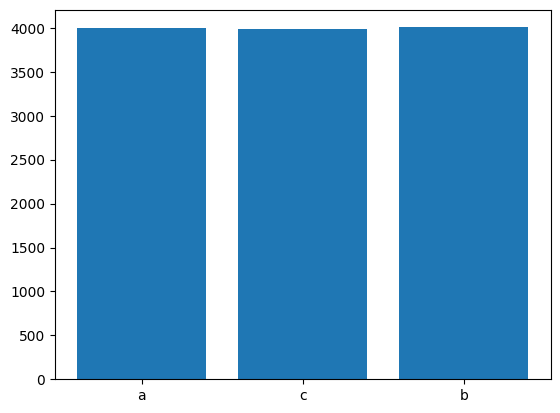

In [15]:

compte_resultats(['a', 'b', 'c'], choix_uniforme)

## Premier essai de tirage pondéré : dupliquer les éléments de la collection

Puisqu'on sait tirer uniformément dans une collection, on peut "tricher" en dupliquant chaque élément autant de fois que l'indique son poids, et tirer uniformément dans cette collection.

In [16]:
def choix_pondere_naif(population):  # ici population est supposé être un dictionnaire
    population_avec_doublons = []
    for cle in population:
        poids = population[cle]
        for i in range(poids):
            population_avec_doublons.append(cle)
    return choix_uniforme(population_avec_doublons)
        

In [28]:
choix_pondere_naif({'a': 1, 'b': 3, 'c': 2})

'c'

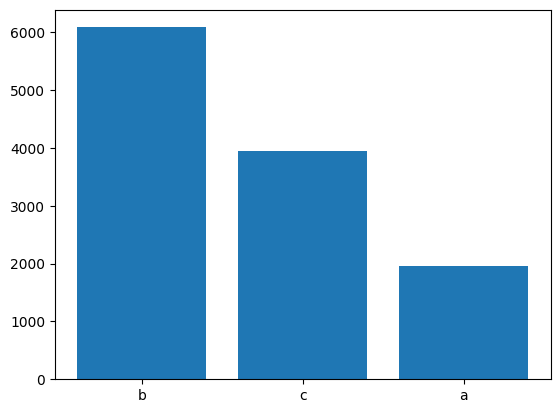

In [29]:
compte_resultats({'a': 1, 'b': 3, 'c': 2}, choix_pondere_naif)

## Deuxième essai : avec calcul des poids cumulés

**Idée :** on calcule la somme des poids $S$, et on partitionne l'intervale des entiers de 0 à $S-1$ en `len(populations)` intervalles successifs correspondant à chacun des éléments de `population`. Ensuite, on fait un tirage uniforme d'un entier entre $0$ et $S-1$, et on associe l'entier tiré à l'intervalle correspondant.

**Tâches :**
- choisir un type de données approprié pour représenter ces intervalles ;
- compléter la fonction `poids_cumules` calculant ces intervalles pour un dictionnaire `population` donné, et en renvoyant sa représentation (ainsi que la valeur de $S$).

In [43]:
def poids_cumules(population):
    res = []
    somme = 0
    for cle, poids in population.items():
        somme += poids
        res.append((somme, cle))
    return res

In [44]:
poids_cumules({'a': 1, 'b': 3, 'c': 2})  # devrait renvoyer [1, 4, 6]

[(1, 'a'), (4, 'b'), (6, 'c')]

Étant donnés un entier `n` et l'objet `cumuls` calculé précédemment, on veut maintenant pouvoir déterminer à quel intervalle de `cumuls` appartient `n`. Par exemple, si $(c_i)_{0 \leq i \leq k}$ représente la suite des cumuls, on cherche le plus grand indice $i$ tel que $c_i \leq$ `n` (ou de manière équivalente, le plus petit indice $i$ tel que `n` $< c_i$). C'est cet indice qui nous indiquera à quel intervalle appartient l'entier `n`  (et donc à quel élément de la population d'origine il correspond).

In [45]:
def trouve_intervalle(population, n):
    cumuls = poids_cumules(population)
    for (borne, element) in cumuls:
        if n < borne:
            return element
    return None  # ne devrait pas se produire ! n incorrect

In [46]:
trouve_intervalle({'a': 1, 'b': 3, 'c': 2}, 6)

In [47]:
for i in range(6):
    print(trouve_intervalle({'a': 1, 'b': 3, 'c': 2}, i))

a
b
b
b
c
c


**Pour aller plus loin :**
- pour optimiser cette fonction, puisque la structure `cumuls` est (si vous l'avez bien choisie) triée par poids cumulés croissants, on peut utiliser un algorithme de *dichotomie* plutôt qu'une recherche exhaustive (Cf. programme de NSI terminale / AP2).
- pour le projet, une fois les poids calculés sur le corpus, il serait préférable de stocker directement les cumuls plutôt que les poids individuels pour éviter d'avoir à le faire à chaque tirage.

On peut maintenant rassembler tous ces éléments pour obtenir un tirage pondéré un peu plus sobre.

In [48]:
def choix_pondere(population):
    i = randrange(sum(population.values()))
    return trouve_intervalle(population, i)

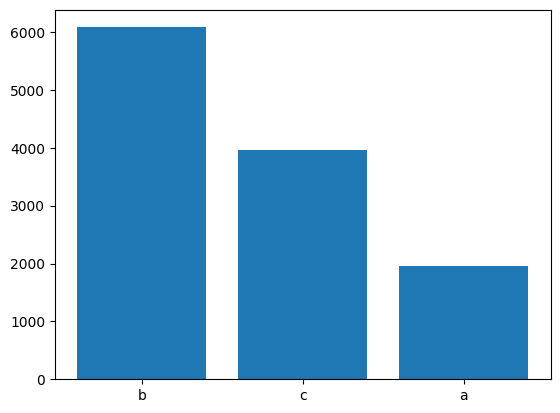

In [49]:
compte_resultats({'a': 1, 'b': 3, 'c': 2}, choix_pondere)

## Et dans la bibliothèque standard ?

In [50]:
population = ['a', 'b', 'c']
poids = [1, 3, 2]

Tirage uniforme :

In [51]:
from random import choice
choice(population)

'c'

Calcul des poids cumulés (facultatif) :

In [52]:
from itertools import accumulate
list(accumulate(poids))

[1, 4, 6]

Tirage pondéré :

In [53]:
from random import choices
choices(population, poids)

['a']

*Variante :*

In [54]:
cumuls = list(accumulate(poids))
choices(population, cum_weights=cumuls)  # plus rapide en principe

['b']

Vérification juste pour voir :

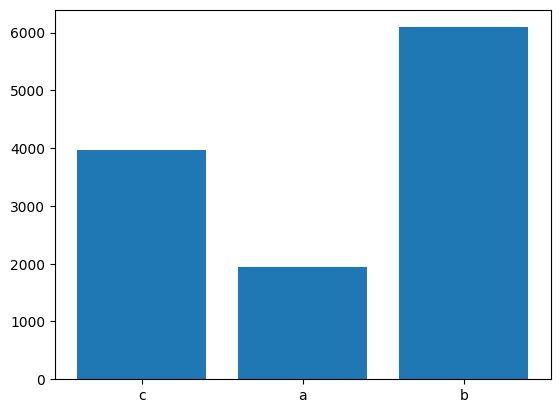

In [55]:
def choix_pondere_natif(population):
    elems = list(population.keys())    # urgh...
    poids = list(population.values())  # urgh...
    return choices(elems, poids)[0]

compte_resultats({'a': 1, 'b': 3, 'c': 2}, choix_pondere_natif)

## Un petit test

In [57]:
%timeit choix_pondere_naif(dict(zip(['a', 'b', 'c'], [32200, 77800, 21200])))
%timeit choix_pondere(dict(zip(['a', 'b', 'c'], [32200, 77800, 21200])))
%timeit choix_pondere_natif(dict(zip(['a', 'b', 'c'], [32200, 77800, 21200])))

3.37 ms ± 153 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.55 μs ± 25.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.58 μs ± 9.77 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
